# PCA Projection of SDSS Spectra

In [1]:
"""
PCA Projection of SDSS Spectra
------------------------------
Figure 7.9

A comparison of the classification of quiescent galaxies and sources with
strong line emission using LLE and PCA. The top panel shows the segregation of
galaxy types as a function of the first three PCA components. The lower panel
shows the segregation using the first three LLE dimensions. The preservation of
locality in LLE enables nonlinear features within a spectrum (e.g., variation
in the width of an emission line) to be captured with fewer components. This
results in better segregation of spectral types with fewer dimensions.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

'\nPCA Projection of SDSS Spectra\n------------------------------\nFigure 7.9\n\nA comparison of the classification of quiescent galaxies and sources with\nstrong line emission using LLE and PCA. The top panel shows the segregation of\ngalaxy types as a function of the first three PCA components. The lower panel\nshows the segregation using the first three LLE dimensions. The preservation of\nlocality in LLE enables nonlinear features within a spectrum (e.g., variation\nin the width of an emission line) to be captured with fewer components. This\nresults in better segregation of spectral types with fewer dimensions.\n'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import manifold, neighbors

from astroML.datasets import sdss_corrected_spectra
from astroML.datasets import fetch_sdss_corrected_spectra
#from astroML.plotting.tools import discretize_cmap
from astroML.utils.decorators import pickle_results

/Users/dagoret/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#------------------------------------------------------------
# Set up color-map properties
clim = (1.5, 6.5)
#cmap = discretize_cmap(plt.cm.jet, 5)
cmap = plt.cm.jet
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']
cticks = [2, 3, 4, 5, 6]
formatter = plt.FuncFormatter(lambda t, *args: cdict[int(np.round(t))])
#------------------------------------------------------------

In [4]:
#------------------------------------------------------------
# Fetch the data; PCA coefficients have been pre-computed
data = fetch_sdss_corrected_spectra()
coeffs_PCA = data['coeffs']
c_PCA = data['lineindex_cln']
spec = sdss_corrected_spectra.reconstruct_spectra(data)
color = data['lineindex_cln']

In [5]:
#------------------------------------------------------------
# Compute the LLE projection; save the results
@pickle_results("spec_LLE.pkl")
def compute_spec_LLE(n_neighbors=10, out_dim=3):
    # Compute the LLE projection
    
    params = {
        "n_neighbors": n_neighbors,
        "n_components": out_dim, 
        "eigen_solver": "dense",
        "random_state": 0,
    }
    
    #LLE = manifold.LocallyLinearEmbedding(n_neighbors, out_dim,
    #                                      method='modified',
    #                                      eigen_solver='dense')
    
    LLE = manifold.LocallyLinearEmbedding(method="modified", **params)
    
    Y_LLE = LLE.fit_transform(spec)
    print(" - finished LLE projection")

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print(" - removing {0} outliers for plot".format(flag.sum()))

    return Y_LLE[~flag], color[~flag]

coeffs_LLE, c_LLE = compute_spec_LLE(10, 3)

@pickle_results: computing results and saving to 'spec_LLE.pkl'
 - finished LLE projection
 - removing 33 outliers for plot


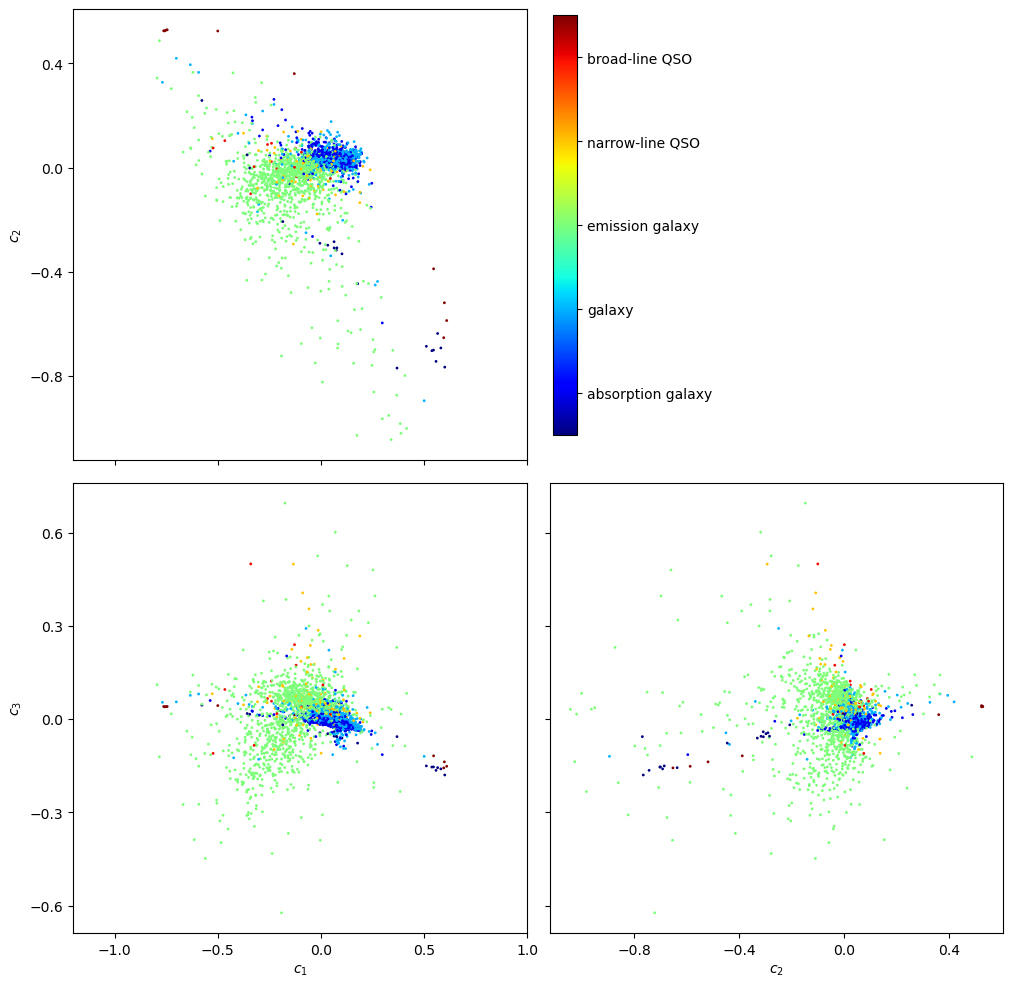

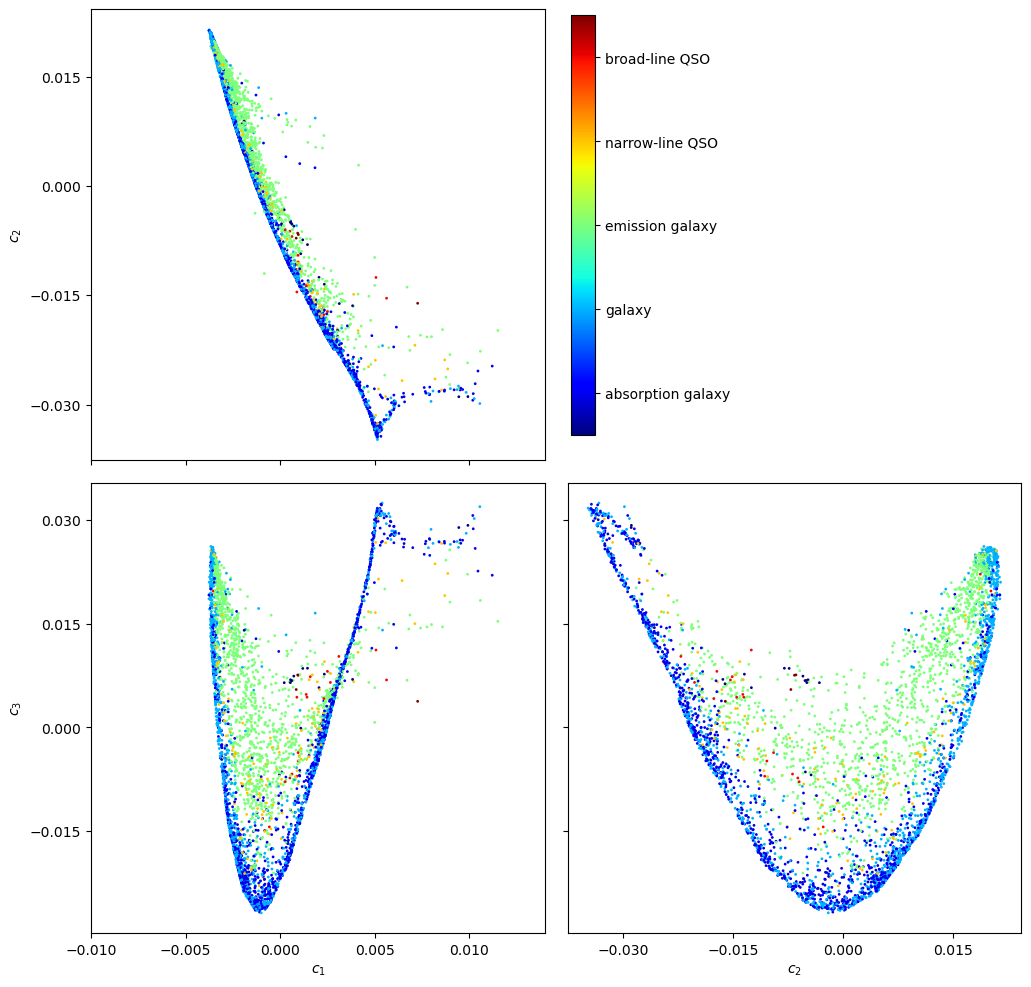

In [6]:

#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_PCA, c_LLE],
                             [coeffs_PCA, coeffs_LLE],
                             [(-1.2, 1.0), (-0.01, 0.014)]):
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(clim)
    ax1.set_ylabel('$c_2$')

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_3$')

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(clim)
    ax3.set_xlabel('$c_2$')

    fig.colorbar(im3, ax=ax3, cax=cax,
                 ticks=cticks,
                 format=formatter)

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()
